In [2]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pinocchio as pin
from pinocchio.utils import rotate
from robot_descriptions.loaders.pinocchio import load_robot_description
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import pink
from pink import solve_ik
from pink.tasks import FrameTask
import qpsolvers
import time
from tqdm import tqdm

from scripts.humanoid_mpc import MPCRobust, feet, foot, MPCForce
from scripts.simulation_utils import compute_initial_position, draw_feet_footprints



## Import robot

In [3]:
robot = load_robot_description(
        "jvrc_description", root_joint=pin.JointModelFreeFlyer()
    )
configuration = pink.Configuration(robot.model, robot.data, robot.q0)
viz = MeshcatVisualizer(robot)
q0 = configuration.q.copy()
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


# Parameters

In [4]:
# Robot parameters
leg_length = 0.75
x_left_foot = 0.096
x_right_foot = - 0.096 
h_ankle = 0.076
#    Estimated robot parameters
h_CoM = leg_length + h_ankle
foot_length = h_CoM * 0.28
foot_width = foot_length / 2

# Step Parameters
T = 0.02            # Sample period
N = 50             # Iteration Window
step_duration = 3  # Step duration
overlap = 50       # Samples in overlap region after each step
duration = 30        # Total walking duration
step_spread_y = foot_length * 0.7 


compute_initial_position(configuration, h_CoM, T)
viz.display(configuration.q)

### Compute MPC

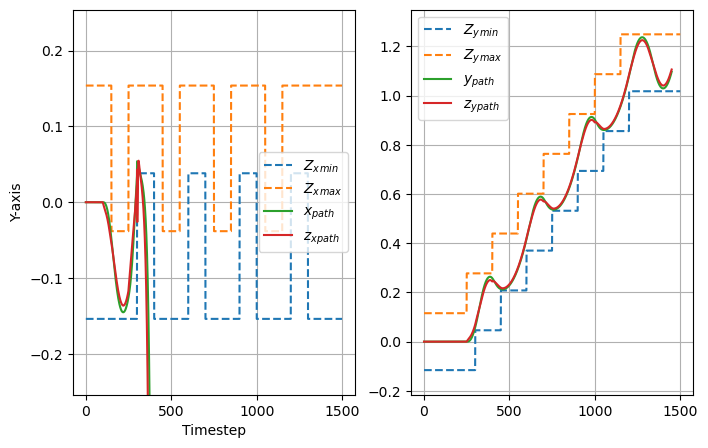

In [18]:
g = 9.81

robot_feet = feet(spread=step_spread_y,
                  length=foot_length,
                  width=foot_width,
                  right=foot(x_right_foot, 0),
                  left=foot(x_left_foot, 0))
mpc = MPCForce(T, N, h_CoM, g, robot_feet, 
                duration=duration, 
                step_duration=step_duration,
                overlap=overlap, 
                force=1
                )

Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x')

Zymin, Zymax = mpc.Zmin[1], mpc.Zmax[1]
y_path, zy_path, jerks = mpc.solve(Zymin, Zymax, coord='y')

feet_tracker = mpc.feet_tracker
n_steps = int(step_duration // T)

fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].plot(Zxmin,'--', label= r'${Z_x}_{min}$')
ax[0].plot(Zxmax,'--', label=r"${Z_x}_{max}$")
ax[0].plot(x_path, label=r"$x_{path}$")
ax[0].plot(zx_path, label=r"${z_x}_{path}$")
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('X-axis')
min_yaxis, max_yaxis = min(Zxmin)-0.1, max(Zxmax)+0.1
ax[0].set_ylim(min_yaxis, max_yaxis)
ax[0].grid()
ax[0].legend()

ax[1].plot(Zymin,'--', label= r'${Z_y}_{min}$')
ax[1].plot(Zymax,'--', label=r"${Z_y}_{max}$")
ax[1].plot(y_path, label=r"$y_{path}$")
ax[1].plot(zy_path, label=r"${z_y}_{path}$")
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('Y-axis')
ax[1].set_ylim(min(Zymin)-0.1, max(Zymax)+0.1)
ax[1].grid()
plt.legend()



# Move robot

In [19]:
draw_feet_footprints(mpc.right_trajectory, 'right', foot_length, foot_width, viz)
draw_feet_footprints(mpc.left_trajectory, 'left', foot_length, foot_width, viz)

### Reset position:

In [20]:
configuration = pink.Configuration(robot.model, robot.data, robot.q0)
compute_initial_position(configuration, h_CoM,T)
viz.display(configuration.q)

In [21]:
root_task = FrameTask("root_joint", position_cost=1.0, orientation_cost=1.0)
left_ankle_task = FrameTask("l_ankle", position_cost=1.0, orientation_cost=1.0)
right_ankle_task = FrameTask("r_ankle", position_cost=1.0, orientation_cost=1.0)

n_steps = step_duration // T
last_left_y = 0
last_right_y = 0
for i in tqdm(range(len(x_path))):

    root_pose = configuration.get_transform_frame_to_world("root_joint").copy()
    root_pose.translation[0] = -x_path[i]
    root_pose.translation[1] = y_path[i]

    root_task.set_target(root_pose)
     
    left_foot, right_foot = feet_tracker[i]
    
    z_x = zx_path[i]
    z_y = zy_path[i]
    left_foot_pose = configuration.get_transform_frame_to_world("l_ankle").copy()
    right_foot_pose = configuration.get_transform_frame_to_world("r_ankle").copy()
    
    
    left_foot_pose.translation[2] = h_ankle
    right_foot_pose.translation[2] = h_ankle
    left_foot_pose.translation[0] = -x_left_foot
    right_foot_pose.translation[0] = -x_right_foot

    if left_foot and not right_foot:
        left_foot_pose.translation[1] = z_y
    if not left_foot and right_foot:
        right_foot_pose.translation[1] = z_y
    if left_foot and right_foot:
        pass    
    left_ankle_task.set_target(left_foot_pose)
    right_ankle_task.set_target(right_foot_pose)
    if i % n_steps == 0:
        print(f'Starting step!')
    if (i + overlap) % n_steps == 0:
        print('Starting Overlap')
    velocity = solve_ik(configuration, [root_task, left_ankle_task, right_ankle_task], T, solver='daqp')
    configuration.integrate_inplace(velocity, T)
    viz.display(configuration.q)
    time.sleep(T)


  0%|          | 2/776 [00:00<01:15, 10.28it/s]

Starting step!


 13%|█▎        | 100/776 [00:10<01:16,  8.86it/s]

Starting Overlap


 19%|█▉        | 150/776 [00:15<00:59, 10.57it/s]

Starting step!


 32%|███▏      | 249/776 [00:24<00:45, 11.64it/s]

Starting Overlap


 39%|███▊      | 299/776 [00:29<00:48,  9.87it/s]

Starting step!


 51%|█████▏    | 398/776 [00:39<00:46,  8.11it/s]

Starting Overlap


 58%|█████▊    | 448/776 [00:45<00:42,  7.64it/s]

Starting step!


 63%|██████▎   | 487/776 [00:48<00:28, 10.08it/s]


AssertionError: 